[*********************100%***********************]  1 of 1 completed
[154.3103562559444, -4.654441701042877, -9.999997275216243, 27.11864280333993, 8.061895328339276, -6.046509736719341, -2.599389560940879, -8.122206754032335, -7.425739496933648, 129.77940934777882, -10.923653923442833, 0.15205619534499615, -7.6738626004617005, 13.64226763843146, -4.748303865898073, 2.975992821093154, 54.850262884429, 13.519764759272634, 1.127245225196516, 30.85924292980218, -2.6718917283718113, 3.1213445643775373]
Total return: 1049.25%


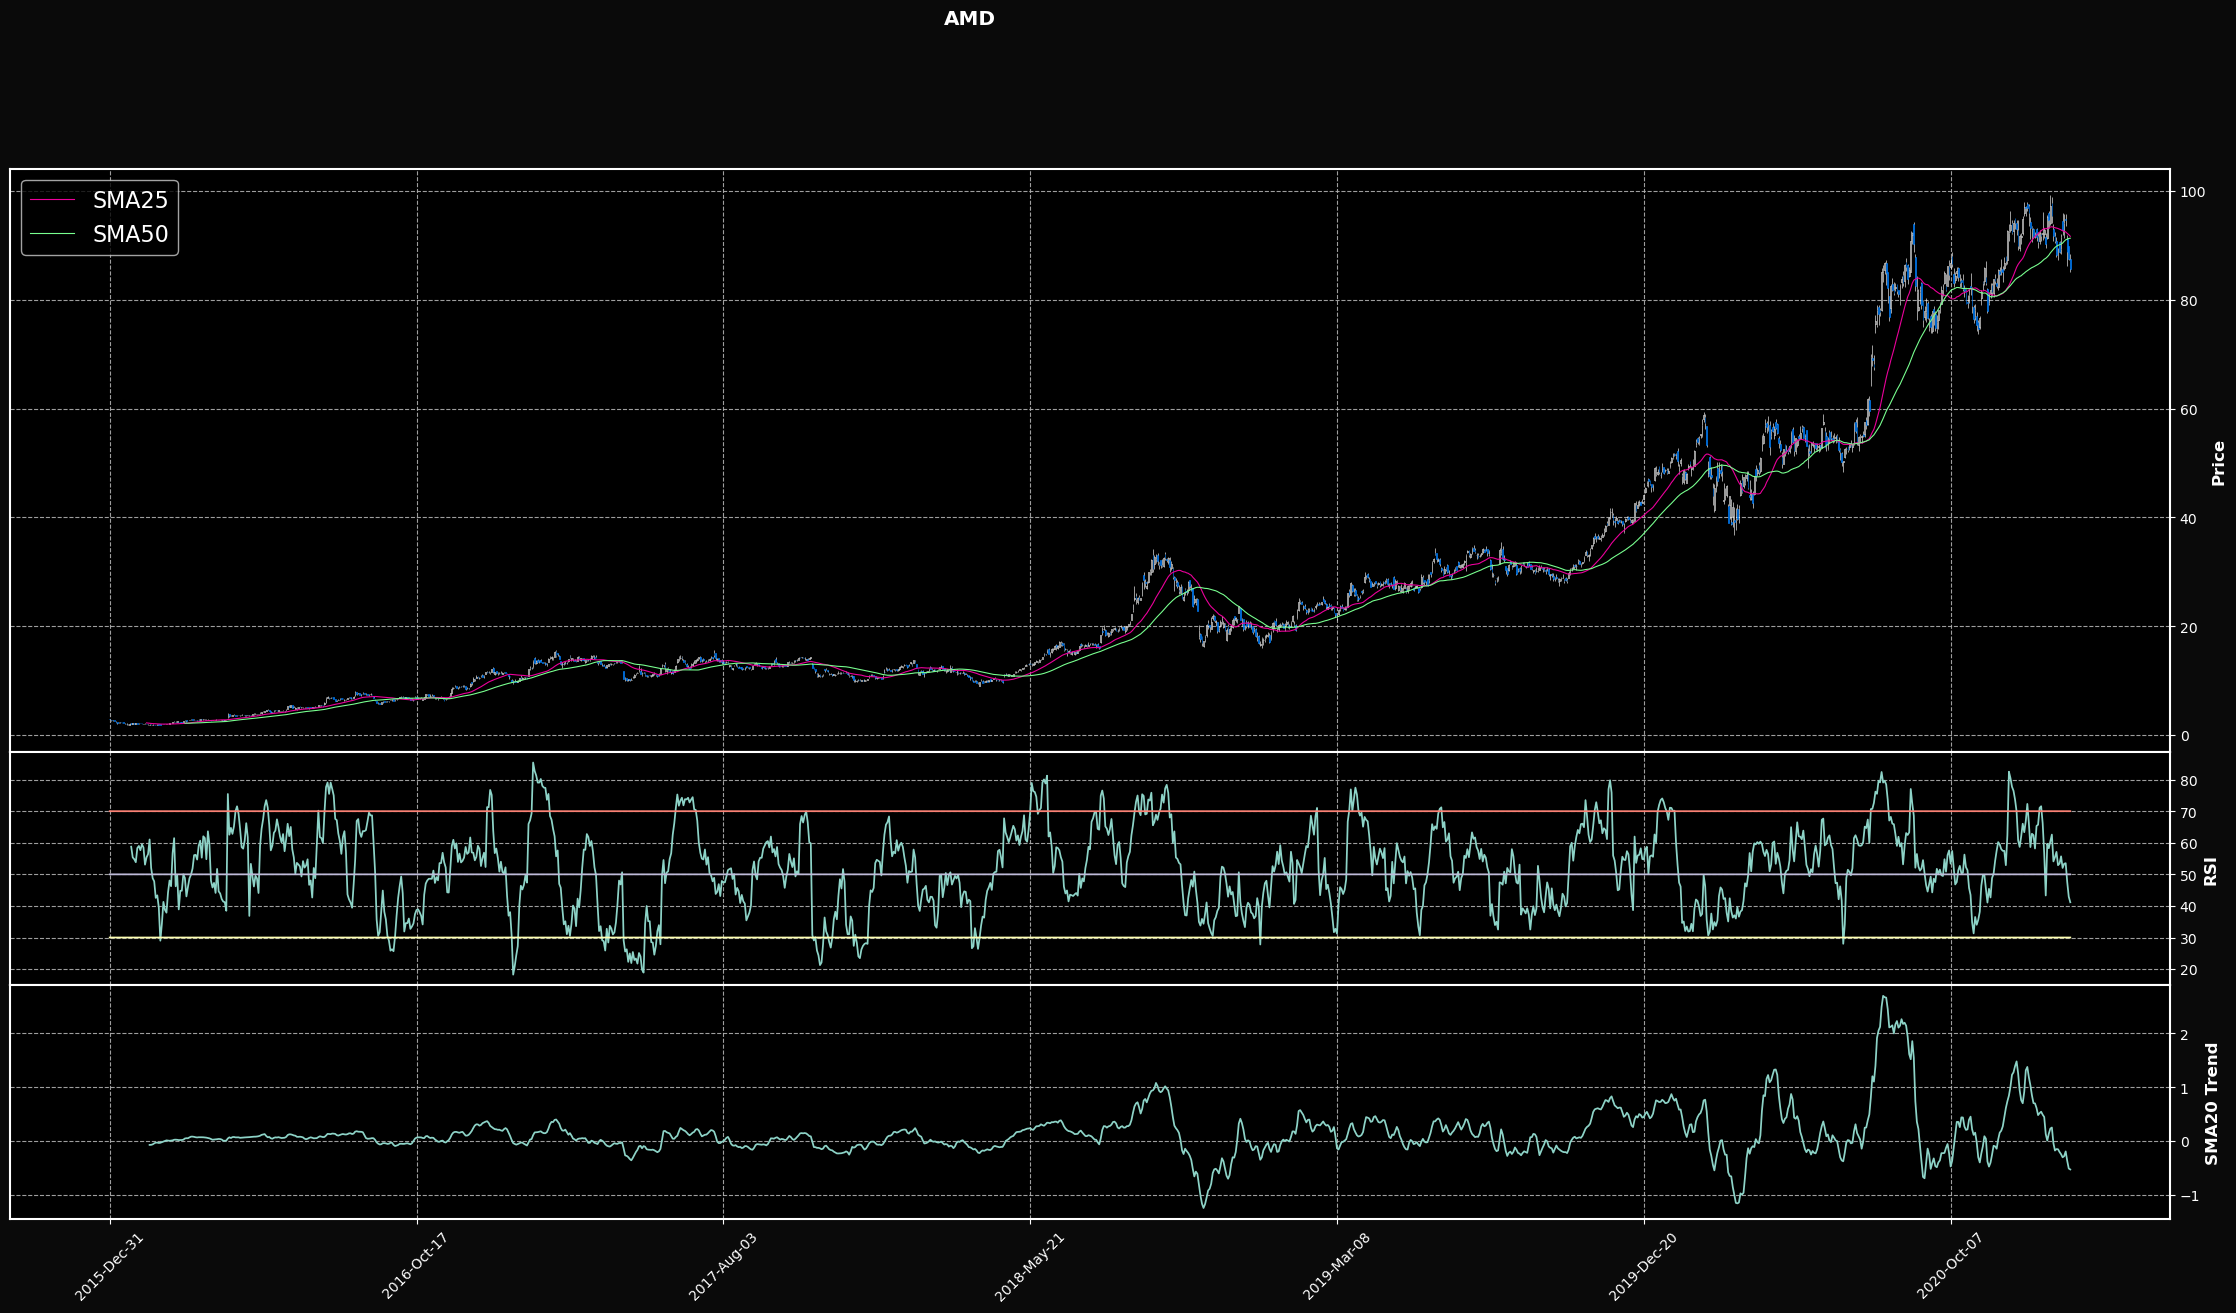

In [5]:
import numpy as np
import pandas as ps
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpl

start = '2016-01-01'
end = dt.datetime.now()
stock_code = 'AMD' # AMD: 988.6%
# stock_code = '^GSPC'
df = yf.download(stock_code, start, end, interval='1d')
term = 14

# calculate stock price difference between yesterday and today.
terms = [25, 50]
for term in terms:
    df['SMA'+str(term)] = df['Adj Close'].rolling(window=term).mean()

def diff(x):
    return x[-1] - x[0]

# 差分を出している
df['Change'] = df['Adj Close'].rolling(window=2).apply(diff)

# calculate rsi
def rsi(x):
    negative_list, positive_list = [i for i in x if i < 0], [i for i in x if i > 0 or i == 0]
    if len(negative_list) == 0:
        return 100
    elif len(positive_list) == 0:
        return 0
    else:
        negative_ave, positive_ave = -sum(negative_list)/len(negative_list), sum(positive_list)/len(positive_list)
        return positive_ave/(negative_ave+positive_ave) * 100

df['RSI'] = df['Change'].rolling(window=14).apply(rsi)

# calculate trend
# 傾きを求めている過去３日分で求めている
trends = [3]
# 3日間で最後と最初の差を見て傾きを出している
def grad(x):
    grad = x[-1] - x[0]
    return grad

for term in trends:
    name = 'SMA25 Trend'
    df[name] = df['SMA25'].rolling(window=term).apply(grad)


# buy if RSI < 30% and RSI Trends5 > 0
# sell if RSI > 70% and RSI Trends5 < 0
position = 0
percentChange = []
for i in df.index:
    rsi = df['RSI'][i]
    close = df['Adj Close'][i]
    sma_short = df['SMA25'][i]
    sma_long = df['SMA50'][i]
    sma_trend = df['SMA25 Trend'][i]
    if np.isnan(rsi):
        continue
    else:
        if rsi > 50 and close and sma_long and sma_trend > 0:
            if position == 0:
                position = 1
                buy_price = close
#         売る
        elif close < sma_long:
            if position == 1:
                position = 0
                sell_price = close
                percent = (sell_price / buy_price - 1) * 100
                percentChange.append(percent)
                
print(percentChange)
total_return = 1
for i in percentChange:
    total_return = total_return * ((i/100) + 1)
total_return = round((total_return - 1)*100, 2)
print('Total return: {}%'.format(total_return))
# plot chart
df['70'] = 70
df['30'] = 30
df['50'] = 50
df['0'] = 0
apds = [
    mpl.make_addplot(df[['RSI', '30', '50', '70']], panel=1, type='line', ylabel='RSI'),
    mpl.make_addplot(df[['SMA25 Trend']], panel=2, type='line', ylabel='SMA20 Trend')
]
fig, ax = mpl.plot(df, mav=(25, 50), type='candle',figsize=(30, 15), style='mike', addplot=apds, title=str(stock_code), returnfig=True)
legend = ['SMA25', 'SMA50']
ax[0].legend(legend, fontsize=16)